One small change as been done in our Value object. Please note that \
\
The __radd__() functionality has been added.

In [1]:
from graphviz import Digraph

def trace(root):
    #Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR == Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            #If this value is a result of some operation, then create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #Connect n1 to the node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:
import math

In [20]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #Its an empty function by default. This is what will do that gradient calculation at each of the operations.
        self._prev = set(_children)
        self._op = _op
        self.label = label


    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad

        out._backward = backward
        return out

    def __radd__(self, other): #here
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
        out._backward = backward
        return out

    def __rmul__(self, other):   #other * self
        return self * other

    def __truediv__(self, other):  #self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):  #self - other
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def backward():
          self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def backward():
          self.grad += 1 - (t**2) * out.grad

        out._backward = backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')   #We merged t and out, into just out

        def backward():
            self.grad += out.data * out.grad

        out._backward = backward
        return out

    def backward(self):

      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

---------------

In [4]:
import random

In [21]:
class Neuron:
	def __init__(self, nin):
		self.w = [ Value(random.uniform(-1,1)) for _ in range(nin) ]
		self.b = Value(random.uniform(-1,1))

	def __call__(self, x):
		# (w*x)+b
		act = sum( (wi*xi for wi,xi in zip(self.w, x)), self.b )
		out = act.tanh()
		return out

class Layer:
	def __init__(self, nin, nout):
		self.neurons = [Neuron(nin) for _ in range(nout)]

	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs)==1 else outs  #The New added line for making the output better

class MLP:
	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.33393070997191954)

-----------

Now, we are creating a very simple dataset. Where we feed a list of values which we would like the NN to take as input.\
\
Along with the list of desired output targets. \
So whenever we give the values xs into the NN, we want the output values to be those in ys respectively. \

&nbsp;

It's almost like a simple Binary Classification. It needs to be either 1.0 or -1.0 in our example.

In [24]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

Now, ys is what WE WANT. \
\
Lets see what our NN thinks of those inputs

In [25]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.33393070997191954),
 Value(data=-0.7996605801165794),
 Value(data=-0.053910703703307694),
 Value(data=-0.5691658715750736)]

-------

So we can see how the outputs we have received are different from what we need \
\
first and fourth one needs to be increased slighly to reach our desired value. \
\
And the second, third one needs to be decreased.

-------

So now how do train/tune the NN or how do tune the weights in order to get our desired output.

&nbsp;

The trick in NN is to calculate a single value that contains the sum of the total performance of your NN. **And that will be the loss value.**


----------

So this loss, will give us an intuition on how well the NN is performing. \
\
Right now in our example, it is not performing very well, as the values are way off. **Therefore the loss will be high and we need to look to minimize the loss.**

-------

So in this particular situation/example, we are going to do/**calculate the Mean Squared Error Loss.**

So first we take the 'y ground truth (ygt)' and then 'y output (yout)'. We will be pairing them together in the loop

In [ ]:
for ygt, yout in zip(ys, ypred)

And then we will be subtracting each of those values and then squaring them

Now that will give us the loss for each of those individual values

In [11]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.2551293266642757),
 Value(data=1.5689343597801393),
 Value(data=1.942823557477381),
 Value(data=0.2264329556998548)]

So depending on how off your pred value is from the expected one, the higher th value will be \
\
That expression is written in such a way that, only when the yout and ygt are close to each other, it will become 0. Therefore no loss in that case \
\
So the aim is to make the loss as small as possible

Now, as mentioned before. **The final loss will just be the sum of all those numbers.**

In [26]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.176873511248545)

*Note: There was an error here where int could not be added to a Value. So I have made the modification in the Value object to handle that :)*

In [27]:
loss.backward()

Something cool really happended when you ran that last cell

In [28]:
n.layers[0].neurons[0].w[0]

Value(data=-0.22585628440403194)

In [29]:
n.layers[0].neurons[0].w[0].grad

3.080379043409595

So now we have extracted the value and its grad value for one particular neuron!

-------

Lets look at the graph of the loss. That will give us a bigger graph, as if you would notice in the mean squared error expression that we wrote, we are passing each of the neuron to it.

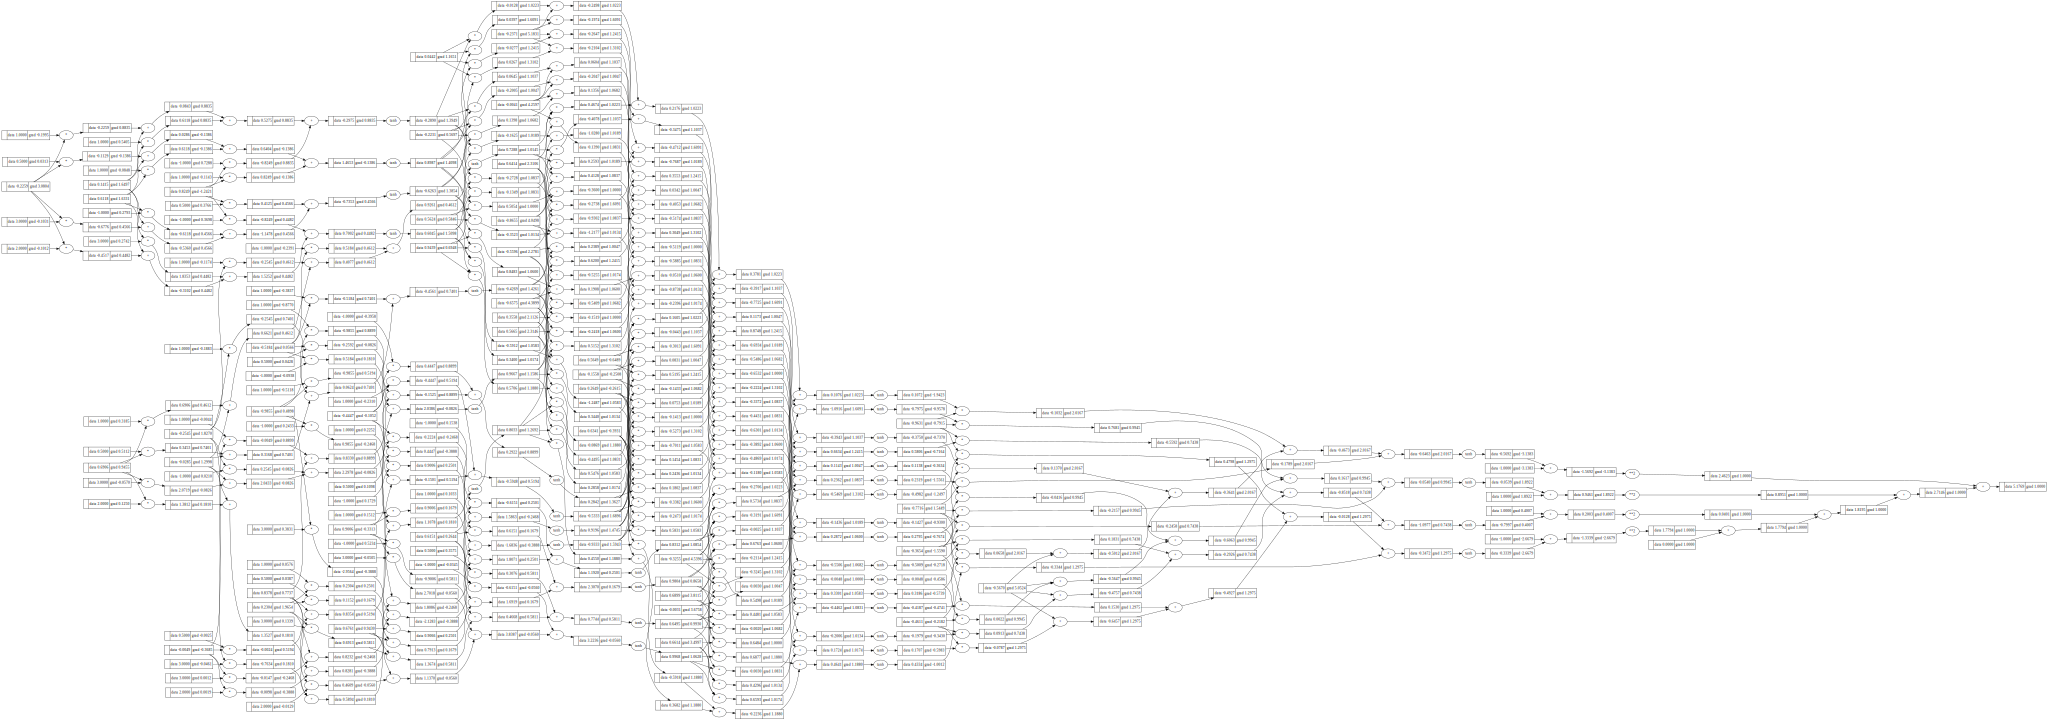

In [30]:
draw_dot(loss)

PHEEWWWW THAT WAS AWESOME LMAO

We have like 4 different foward pass and finally calculating the loss \
\
Not only that, we have also backpropagated throughout the entire graph!